In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy

plt.rcParams.update({
    'figure.facecolor': '#121212',
    'figure.figsize': (12, 6),
    'axes.facecolor': '#1e1e1e',
    # 'axes.edgecolor': '#4a90e2',
    'lines.linewidth': 1,
    # 'lines.color': '#4a90e2',
    'text.color': '#cccccc',
    'axes.labelcolor': '#cccccc',
    'xtick.color': '#bbbbbb',
    'ytick.color': '#bbbbbb',
    # 'axes.titlecolor': '#4a90e2',
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 
    12,
    'ytick.labelsize': 12,
    'grid.color': '#333f58',
    'grid.linestyle': '--',
    'grid.linewidth': 0.7,
    'axes.grid': True,
    'legend.facecolor': '#2c2c2c',
    # 'legend.edgecolor': '#4a90e2',
    'legend.fontsize': 12,
    'legend.fancybox': True,
    'savefig.facecolor': '#121212',
    'savefig.edgecolor': '#121212',
})

np.set_printoptions(
    formatter={'float_kind': lambda x: f"{x:.2e}"}
    #formatter={'float_kind': lambda x: f"{x:.2g}"},
    #suppress=False 
)





In [4]:
# constants:
A = 0.84
kappa = 1.7e1
H = 12
L = 1.9e4
r = 0.24
h0 = 0.0025
# h0 = 0.00025
omega = 1.4e-4

# bottom friction coefficient
g = 9.81
n = 0.03
rho = 1000
c_d = g * n**2

print(c_d)

0.008829


In [ ]:



def perform_numerical_computation(A, kappa, H, r, h0, nx, nt = None):

    dx = 1 / nx

    dt = 0.9 / np.sqrt(kappa) * dx
    nt = int(10 / dt)

    print(dt, dx)


    x_x = np.linspace(-dx, 1 + dx, nx + 2)

    u_xt_ = np.zeros((nx + 2, nt + 1))
    D_xt_ = np.zeros((nx + 2, nt + 1))
    l_t_ = np.zeros(nt + 1)

    D_xt_[0, 0] = 1 + A / H
    D_xt_[:, 0] = (H + A) / H - x_x # since x_x = h_x
    l_t_[0] = 1 # 2e4 / 1.9e4



    def update_l(l__t, u_x_t, dt):
        return l__t + u_x_t[-2] * dt

    def update_D(l__t1, l__t2, u_x_t, x_x, D_x_t, dt, dx, t):
        D_x_t2 = np.zeros(nx + 2)
        D_x_t2[0] = A / H * np.cos(t) + 1
        D_x_t2[-1] = 0 # redundant


        dDdx =  (D_x_t[2:] - D_x_t[:-2]) / (2 * dx)
        dDudx = (D_x_t[2:] * u_x_t[2:] - D_x_t[:-2] * u_x_t[:-2]) / (2 * dx)


        D_x_t2[1:-1] = (D_x_t[2:] + D_x_t[:-2]) / 2 \
                        + x_x[1:-1] / l__t1 * (l__t2 - l__t1) * dDdx \
                        - dt / l__t1 * dDudx
        
        return D_x_t2


    def update_u(l__t1, l__t2, u_x_t, x_x, h_x, D_x_t, D_x_t2, dt, dx):
        # print(dt)
        # Lambda_start = c_d * np.abs(u_x_t[0]) / 2 / (D_x_t2[0] + h0)
        # Lambda_middle = c_d * np.abs(u_x_t[:-2] + u_x_t[2:]) / 2 / (D_x_t2[1:-1] + h0)
        # Lambda_end = c_d * np.abs(u_x_t[-1]) / 2 / (D_x_t2[-1] + h0)

        # 


        def residual(u):

            res = np.zeros(nx + 2)

            dudx = (-3 * u[0] + 4 * u[1] - u[2]) / (2*dx)
            dDdx = (-3 * D_x_t[0] + 4 * D_x_t[1] - D_x_t[2]) / (2*dx)
            dhdx = (-3 * h_x[0] + 4 * h_x[1] - h_x[2]) / (2*dx)

            res[0]    = (
                                u_x_t[0] \
                                + dt / l__t1 * u[0] * dudx 
                                - dt / l__t1 * kappa * (dDdx + dhdx)
                                - dt * c_d * np.sign(u_x_t[0]) /  2 / (D_x_t2[0] + h0)
                            ) - u[0]

            dudx = -(-3 * u[-1] + 4 * u[-2] - u[-3]) / (2*dx)
            dDdx = -(-3 * D_x_t[-1] + 4 * D_x_t[-2] - D_x_t[-3]) / (2*dx)
            dhdx = -(- 3 * h_x[-1] + 4 * h_x[-2] - h_x[-3]) / (2*dx)

            res[-1]   = (
                                u_x_t[-1] \
                                + dt / l__t1 * ((l__t2 - l__t1) / dt - u[-1]) * dudx # this is zero???
                                - dt / l__t1 * kappa * (dDdx + dhdx)
                                - dt * c_d * np.sign(u_x_t[-1]) /  2 / (D_x_t2[-1] + h0)
                            ) - u[-1]
            
            dudx = (u[2:] - u[:-2]) / (2*dx)
            dDdx = (D_x_t[2:] - D_x_t[:-2]) / (2*dx)
            dhdx = (h_x[2:] - h_x[:-2]) / (2*dx)
            
            res[1:-1] = (
                                (u_x_t[2:] + u_x_t[:-2]) / 2 \
                                + dt / l__t1 * (x_x[1:-1] * (l__t2 - l__t1) / dt - u[1:-1]) * dudx \
                                - dt / l__t1 * kappa * (dDdx + dhdx) \
                                - dt * c_d * np.sign(u_x_t[1:-1]) /  2 / (D_x_t2[1:-1] + h0)
                            ) - u[1:-1]
            
            return res



        guess = u_x_t


        sol = scipy.optimize.root(residual, guess).x


        # print(A)
        # print(D)
        # print(u_x_t)
        # print(sol)

        # norm = np.linalg.norm(sol - u_x_t[1:-1])
        # print(solution1)
        # print(solution2)

        # print(norm, norm1, norm2)

        # u_x_t2[1:-1] = sol


        
        return sol


    for timestep in range(nt):
        if timestep % 1000 == 0:
            print(timestep)
        l_t_[timestep + 1] = update_l(l_t_[timestep], u_xt_[:, timestep], dt)
        D_xt_[:, timestep + 1] = update_D(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, D_xt_[:, timestep], dt, dx, timestep * dt)
        u_xt_[:, timestep + 1] = update_u(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, x_x * l_t_[timestep], D_xt_[:, timestep], D_xt_[:, timestep + 1], dt, dx)

    t = np.linspace(0, dt * nt, nt + 1)
    return t, x_x, l_t_, D_xt_, u_xt_




0.002182820625326997 0.01
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


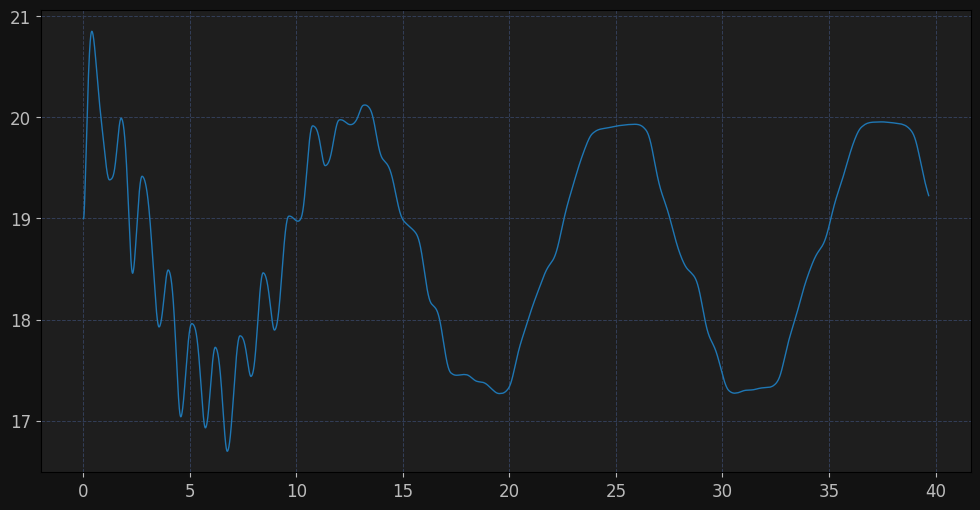

0.000727606875108999 0.0033333333333333335
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


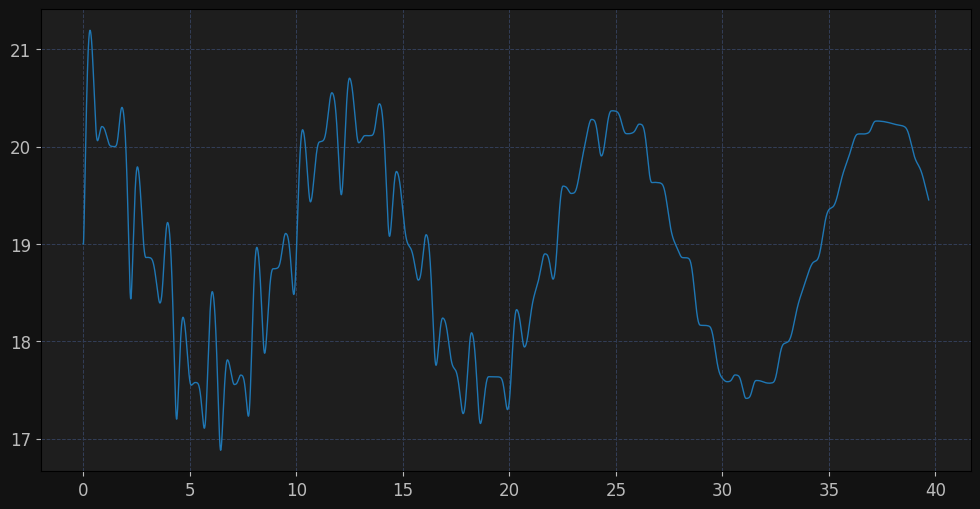

0.0004365641250653994 0.002
0
1000
2000
3000
4000


KeyboardInterrupt: 

In [6]:
nx = 500

for nx in [100, 300, 500]:

    t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, r, h0, nx)
    #plt.plot(t[len(t)*3//4:] / omega / 3600, l_t_[len(t)*3//4:] * L / 1000)
    plt.plot(t / omega / 3600, l_t_ * L / 1000)
    plt.show()




In [ ]:
nx = 1000
t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, r, h0, nx)


0.0002182820625326997 0.001


[np.int64(15112), np.int64(16839), np.int64(18566), np.int64(20293), np.int64(22020), np.int64(23747)]


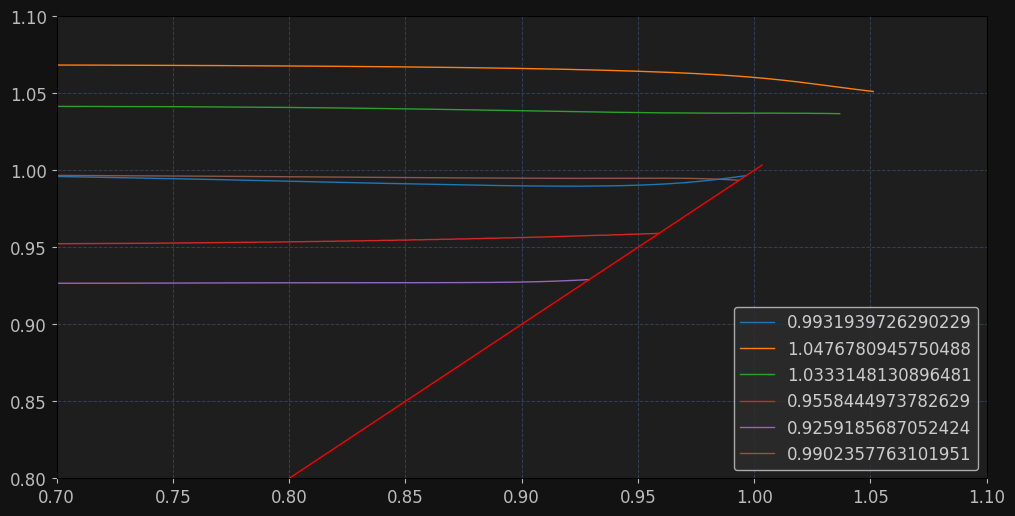

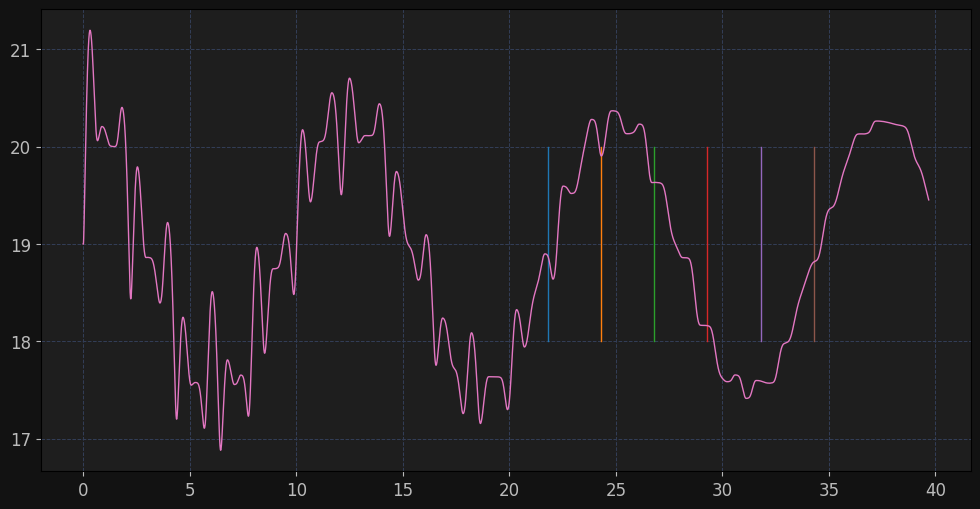

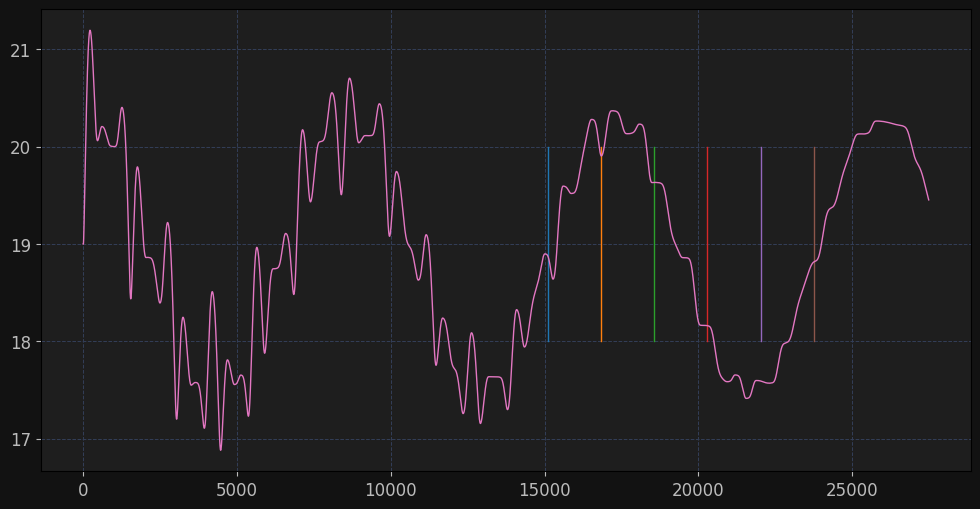

In [7]:

target_times = np.array([1/5, 2/5, 3/5, 4/5, 5/5, 6/5]) + 1.55
target_time_idxs = [np.argmin(np.abs(t - target_time * 2 * np.pi)) for target_time in target_times]
print(target_time_idxs)

for target_time_idx in target_time_idxs:
    # D = (D_xt_[:, target_time_idx] + x_x * l_t_[target_time_idx]) /  l_t_[target_time_idx]
    D = (D_xt_[:, target_time_idx] + x_x * l_t_[target_time_idx])# /  l_t_[target_time_idx]


    plt.plot(x_x * l_t_[target_time_idx], D)

plt.plot(x_x, x_x, 'r')
plt.xlim([0.7, 1.1])
plt.ylim([0.8, 1.1])
plt.legend([str(l_t_[target_time_idx]) for target_time_idx in target_time_idxs])



# plt.plot(t[:target_time_idx] / omega / 3600, l_t_[:target_time_idx] * L / 1000)
plt.show()



T = (2*np.pi) / omega

for idx in target_time_idxs:
    plt.plot(np.array([t[idx], t[idx]]) / omega / 3600, [18, 20])

plt.plot(t / omega / 3600, l_t_ * L / 1000)

plt.show()



for idx in target_time_idxs:
    plt.plot(np.array([idx, idx]), [18, 20])
plt.plot(l_t_ * L / 1000)
plt.show()






In [8]:
print(len(t))

n = 15

t_idx_min = np.argmin(np.cos(t[40000:50000])) + 40000
print(t_idx_min)
t_min = t[t_idx_min]
print(t_min)
print(3 * np.pi)


moments =  np.array(range(n)) * 750 + t_idx_min

for moment in moments:
    plt.plot(x_x, u_xt_[:, moments])
# plt.legend(t[moments] / omega / 3600)
print(t[moments] / omega / 3600)
plt.show()



27488


ValueError: attempt to get argmin of an empty sequence

In [9]:
U = omega * L
nxs =  [100, 500, 1000]
for nx in nxs:
    t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, r, h0, nx)
    maximum_velocities = [max(u_xt_[x, len(l_t_) * 3 // 4:]) for x in range(u_xt_.shape[0])]

    print(u_xt_.shape)

    plt.plot(x_x, np.array(maximum_velocities) * U)


    minimum_velocities = [min(u_xt_[x, len(l_t_) * 3// 4:]) for x in range(u_xt_.shape[0])]

    plt.plot(x_x, np.array(minimum_velocities) * U)

plt.legend(nxs)
plt.show()

0.002182820625326997 0.01
0


KeyboardInterrupt: 